In [1]:
## Import Jupyter Notebook specifics
%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt

## Import numpy
import numpy as np

## Import SimpleElastix
import SimpleITK as sitk

## Import supporting files
import support_files.dataManagement as dataManage
import support_files.image_utilities as image_utilities
import support_files.t1MappingPredict as t1Map


# Introduction to T1 mapping

## Why do we need mapping?
The image formation in a MRI experiment is a complex process. Underlying parameters of differently tissues respond differently to the external magnetic field produced by the machine. This creates changes in image contrast, allowing for tissue differentiation.

However, as most of physical phenomena, this is a noisy procedure, since internal (i.e. variation in tissue susceptibility) and external factors (i.e. inhomogeneity of magnetic fields, imperfect RF pulses) affect the appearance of the final weighted images. This happens because the observed signal amplitudes are not only dependent on the tissue properties, therefore making longitudinal analysis much harder.

## Quantitative mapping
Quantitative mapping aims to reduce the corrupting factors by estimating the invariant tissue property directly from the observed signal. T1 mapping, the focus of this exercise, can be performed in several ways, but the most common approaches are based on statistical iterative algorithms, such as Bayesian inference or the Maximum Likelihood Estimator (MLE).

The optimisation algorithm fits a given signal model to the acquired weighted images to try to recover the tissue properties that best explain the observed signal. In the cases presented here, Inversion Recovery (IR) based sequences were used and the approximated signal model is given by:

$$f_{n}\left(A, B, T_{1}\right)=\left|A-B e^{-\frac{TI_{n}}{T_{1}}}\right|$$

where A is proportional to the proton density of the sample, B is related to the inversion efficiency of the RF pulses, TI<sub>n</sub> is the inversion time for the n<sup>th</sup> image in the series and T<sub>1</sub> is the longitudinal relaxation time in a voxel. 

By varying the time the RF pulse is applied (the TI), the contrast of the images change according to their A, B and T<sub>1</sub> values and the signal model can be used to fit the time series at a voxel. In the figure below you can see how the signal is dependent on the acquisition TI. 


You can observe how the signal from different tissues evolve:

<img src="files/support_images/Synt_T1w.png">

The image above only shows 5 images out of 23 images in total. The plot below shows the signal evolution for gray matter (GM), white matter (WM) and csf. Each point in the curve corresponds to the voxel intensity at a give inversion time.

<img src="files/support_images/T1w_signalEvolution.png">

The estimation algorithm, through iterative optimisation methods, trys to predict which values for T<sub>1</sub>, A and B that could have originated this signal evolution, based on the signal model. In the plot above, by observing the inflexion points, it is possible to infer that T<sub>1,CSF </sub> > T<sub>1,GM </sub> > T<sub>1,WM </sub>.



## Visualising the weighted images
Now you can load and visualise our first example, a set of synthetic weighted images simulated using the signal model above. Explore the variation in signal intensity and check for different signal evolution curves for multiple voxels:

In [10]:
## Loading synthetic data
filePath = "./support_data/synthetic_t1w.h5"
originalSeries, groundTruthMaps, mask = dataManage.loadSyntheticData(filePath, sliceSelect=38)
gt_t1Map = groundTruthMaps

Loading data
Data loaded


<IPython.core.display.Javascript object>


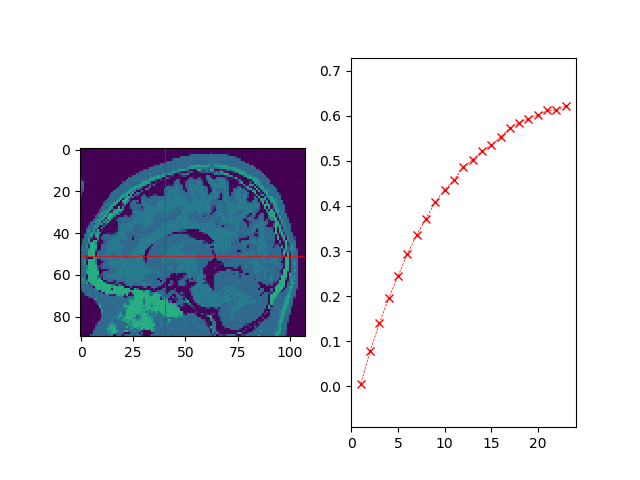

interactive(children=(IntSlider(value=11, description='inversion_time', max=22), IntSlider(value=53, descripti…

In [11]:
## Visualisation
imageBrowse(originalSeries["weighted_series"], im_ax = 0, rang_min = 0.0, rang_max = 1.5)

## How does motion affect the images

### Patient motion

In an Inversion Recovery experiment, to permit the complete relaxation of the signal, the images at each inversion times are acquired spaced from one another. Due to inherent patient movement during the scan, the images at different TI<sub>s</sub> won't be aligned. This means that throughout the time series, a given voxel in the images won't, necessarily, correspond to the same spatial location, since they are misaligned.

In the example below, we introduced simulated motion to the synthetic dataset from before. In the same way as above, you can visualise the different images, and check how the simulated motion affects the signal evolution.

In [ ]:
## Loading motion corrupted data
filePath = "./support_data/synthetic_t1w_deformed.nii"
corruptedSeries = {}
corruptedSeries["weighted_series"] = dataManage.readNii(filePath)
corruptedSeries["echo_times"] = originalSeries["echo_times"]

In [ ]:
## Visualisation
imageBrowse(corruptedSeries["weighted_series"], im_ax = 0, rang_min = 0.0, rang_max = 1.5)

### Impact of motion on T1 mapping
To demonstrate how this affects the mapping results, you can run the cell below. It evoques a MLE-based optimisation method which estimates the A, B and T<sub>1</sub> maps, however, here, we are only interested in the latter. 

In [ ]:
# Define the T1Mapping wrapper
def t1Mapping(data):
    print('-'*40)
    print('T1 estimation started')
    
    configurationFilePath = './support_files/configuration_file_mle.txt'
    predictedMaps = t1Map.predictMapping(data, configurationFilePath, False)
    
    print('T1 estimation finished')
    return np.array(predictedMaps)

In [ ]:
## Run T1 mapping for original data
qMaps, estimatedWeightedSeriesOriginal = t1Mapping(originalSeries)
original_t1Map = qMaps[-1].detach().numpy()

## Run T1 mapping for motion corrupted data
qMaps, estimatedWeightedSeriesCorrupted = t1Mapping(corruptedSeries)
corrupted_t1Map = qMaps[-1].detach().numpy()


### Comparing to the known ground-truth (only in simulated experiments)
An advantage of using simulated data is that the ground-truth maps (A, B and T<sub>1</sub>) are known. To evaluate the precision of the estimation, we can directly compared the estimated maps to the known ground-truth:

In [ ]:
## Comparison plot
image_utilities.compare_predictions(gt_t1Map, original_t1Map)
image_utilities.compare_predictions(gt_t1Map, corrupted_t1Map)
image_utilities.compare_predictions(original_t1Map, corrupted_t1Map)

### Checking the residuals
An effective way to verify if the mapping was performed correctly is to check the residuals of the fitted data. We can use the signal model to generate simulated weighted images, which can be compared to the original observed data. This shows us if the estimated parameters are, indeed, possible solutions to explain the observed data. The optimal residual would yield only noise (i.e. no brain structure should be visible).

In [ ]:
## Calculate and plot the residuals for the non-corrupted estimates
residualOriginal = estimatedWeightedSeriesOriginal - originalSeries["weighted_series"]
imageBrowse(residualOriginal, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

In [ ]:
## Calculate and plot the residuals for the motion corrupted estimates
residualCorrupted = estimatedWeightedSeriesCorrupted - originalSeries["weighted_series"]
imageBrowse(residualCorrupted, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

## Motion compensation - Image registration
As we observed previously, patient motion during the scans can have a negative effect in the estimated maps. Image registration, as performed by Elastix and SimpleElastix, can help with this by aligning the images to each other, reducing the spatial displacement of voxels.

Now, we will use SimpleElastix to perform registration of the corrupted images from the example above. We use SimpleElastix because its integration with Python (and many other languages) is easy. Additionally, the object-oriented structure in which the tool was written gives an intuitive way to use it.

#### Parameter File
As explained previously, Elastix uses a set of instructions to execute. There are several ways to tell Elastix how to perform the registration. Here, for simplicity, we will use a parameter file available in the extensive community-built database. For your convenience, the file is already located in the working directory.

However, if your application demands a different type of data structure, you can go to http://elastix.bigr.nl/wiki/index.php/Parameter_file_database and check what the community made available to us!

In [ ]:
# Define the elastix wrapper
def elastixRegister(fixedImage, movingImage, parameterMapPath):
    print("Applying registration")
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)
    
    parameterMap = sitk.ReadParameterFile(parameterFilePath)
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    
    resultImage = elastixImageFilter.GetResultImage()
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    
    procData = sitk.GetArrayFromImage(resultImage)
    procData = np.transpose(procData, (0,2,1))
    
    print("Registration finished")
    
    return procData, transformParameterMap

In [ ]:
## Perform registration
filePath = "./support_data/synthetic_t1w_deformed.nii"
parameterFilePath = "./ParametersFile/par_groupwise/par_real_data/par_groupwise_DTI-BRAIN.txt"

sitk_fixed, sitk_moving = dataManage.prepareDataForElastix(filePath)
processedData, transformParameterMap = elastixRegister(sitk_fixed, sitk_moving, parameterFilePath)

registeredSeries = {}
registeredSeries['weighted_series'] = processedData
registeredSeries['echo_times'] = originalSeries['echo_times']

#### Visualising registered data
You can now visualise the registered data and compare it to the corrupted and original images. Notice how the signal evolution curve changes for the same voxel in each case. Additionally, although much better than the corrupted images, you still might see a slight misalignment between the registered images. Registration is a hard problem and, without fine tunning of the parameters, results are often suboptimal.

In [ ]:
imageBrowse(originalSeries["weighted_series"], im_ax = 0, rang_min = 0.0, rang_max = 1.5)
imageBrowse(corruptedSeries["weighted_series"], im_ax = 0, rang_min = 0.0, rang_max = 1.5)
imageBrowse(registeredSeries["weighted_series"], im_ax = 0, rang_min = 0.0, rang_max = 1.5)

#### T1 mapping of registered images
After registration, we can now perform the T<sub>1</sub> mapping of the corrected data. We expect improved results compared to the motion corrupted example. However, due to the residual misalignments observed, the T<sub>1</sub> map from the original data has higher accuracy. We can check that by evaluating the residuals of the prediction, as done before.

In [ ]:
# T1 mapping with registered images
qMaps, estimatedWeightedSeriesRegistered = t1Mapping(registeredSeries)
registered_t1Map = qMaps[-1].detach().numpy()

In [ ]:
## Calculate and plot the residuals for the registered estimates
residualRegistered = estimatedWeightedSeriesRegistered - originalSeries["weighted_series"]
imageBrowse(residualRegistered, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

# ---------------------------------------------------------------------------------------
# Now it's your turn!

In the folder './support_data/' you will find an example of in-vivo data, acquired using an Inversion Recovery sequence. The data structure is similar to what was explained above. Using similar steps as before, you should:

1. Load and visualise your data
2. Do the T1 mapping with the original data and check the quality of fit (Check the residual)
3. Perform the image registration (you can use the same parameter file)
4. Again, perform the T1 mapping with the registered data
5. Verify results and compare the estimates of step 4 with the original estimates (step 2).

#### Loading In Vivo data
Implemented for you :)

In [8]:
## This part is given, since the loading method is different.
## Load In-vivo data
filePath = "./support_data/inVivo.mat"
inVivoSeries = dataManage.loadRealData(filePath, 10)


Loading data
Data loaded


#### Visualise the data
Implement me...

<IPython.core.display.Javascript object>


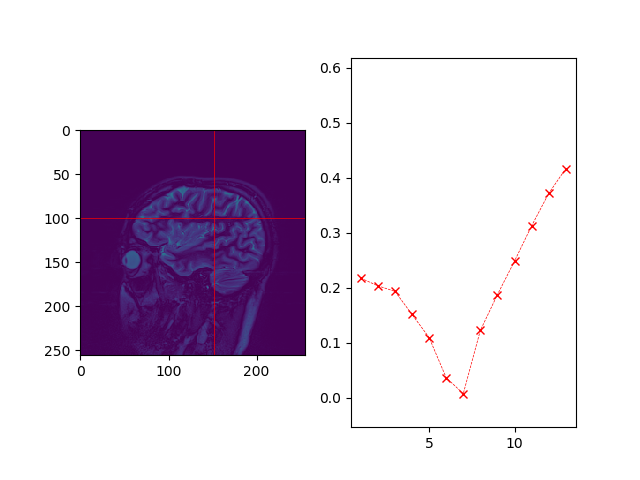

interactive(children=(IntSlider(value=6, description='inversion_time', max=12), IntSlider(value=127, descripti…

In [9]:
imageBrowse(inVivoSeries["weighted_series"], im_ax = 0, rang_min = 0.0, rang_max = 1.5)

#### Perform T1 mapping on original data
Implement me...

In [ ]:
# qMaps, estimatedWeightedSeriesInVivo = t1Mapping(inVivoSeries)
# inVivo_t1Map = qMaps[-1].detach().numpy()

#### Check residuals
Implement me...

In [ ]:
# residualInVivo = estimatedWeightedSeriesInVivo - inVivoSeries["weighted_series"]
# imageBrowse(residualInVivo, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

#### Perform registration
Implement me...

In [ ]:
# filePath = "./support_data/invivo_t1w.nii"
# parameterFilePath = "./ParametersFile/par_groupwise/par_real_data/par_groupwise_DTI-BRAIN.txt"

# sitk_fixed, sitk_moving = dataManage.prepareDataForElastix(filePath)
# processedData, transformParameterMap = elastixRegister(sitk_fixed, sitk_moving, parameterFilePath)

# registeredSeries = {}
# registeredSeries['weighted_series'] = processedData
# registeredSeries['echo_times'] = inVivoSeries['echo_times']

#### Visualise the registered data
Implement me...

In [ ]:
# imageBrowse(registeredSeries['weighted_series'], im_ax = 0, rang_min = 0.0, rang_max = 1.5)

#### Performing T1 mapping on registered data
Implement me...

In [ ]:
# qMaps, estimatedWeightedSeriesInVivoRegistered = t1Mapping(registeredSeries)
# inVivo_t1MapRegistered = qMaps[-1].detach().numpy()

#### Check residuals
Implement me...

In [ ]:
# residualInVivoRegistered = estimatedWeightedSeriesInVivoRegistered - inVivoSeries["weighted_series"]
# imageBrowse(residualInVivoRegistered, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

#### Compare original and registered maps
Implement me...

In [ ]:
# image_utilities.compare_predictions(inVivo_t1Map, inVivo_t1MapRegistered)

# Support method
It requires the interactive window from Jupyter. Please run this cell.

In [4]:
## Visualisation of images
def imageBrowse(im, im_ax=0, rang_min = 0, rang_max = 1.5):
    """imageBrowse: Simple visualisation tool. It accepts 3D or 4D matrices.
        This method plots the 3D or 4D images (if 4D, multiple views are available).
        It also shows the signal evolution for a given point, which can be chosen by mouse interaction.
        
        Input: [C x H x W x D] or [C x H x W], where C is the channel dimension (i.e. Time series)
        Output: None
    """
    
    dim = len(np.shape(im))
    
    if dim == 4:
        x1 = np.shape(im)[1]-1
        x2 = np.shape(im)[2]-1
        x3 = np.shape(im)[3]-1
    if dim == 3:
        x1 = np.shape(im)[2]-1
        x2 = np.shape(im)[1]-1
        x3 = 0
    
    global lr
    global ax_dim
    ax_dim = []
    lr=[]
    
    ax1=50
    ax2=50
    ax3=10
    
    coord = {}
    coord["x"] = 50
    coord["y"] = 50
    coord["z"] = 10
    
    vmin_range=rang_min
    vmax_range=rang_max
    
    it = np.linspace(1,len(im), len(im))
    
    if dim == 4:
        fig, ax = plt.subplots(1,4)
    if dim == 3:
        fig, ax = plt.subplots(1,2)
    
    if dim == 4:
        line0, = [ax[0].imshow(im[im_ax, ax1, :, :], vmin=vmin_range, vmax=vmax_range)]
        line1, = [ax[1].imshow(im[im_ax, :, ax2, :], vmin=vmin_range, vmax=vmax_range)]
        line2, = [ax[2].imshow(im[im_ax, :, :, ax3], vmin=vmin_range, vmax=vmax_range)]
        line3, = ax[3].plot(it, im[:, ax1, ax2, ax3], '--xr', linewidth=0.5)
        ax[3].set_ylim([np.min(im[:, ax1, ax2, ax3])-0.1, np.max(im[:, ax1, ax2, ax3])+0.1])
    if dim == 3:
        line0, = [ax[0].imshow(im[im_ax], vmin=vmin_range, vmax=vmax_range)]
        line3, = ax[1].plot(it, im[:, ax1, ax2], '--xr', linewidth=0.5)
        ax[1].set_ylim([np.min(im[:, ax1, ax2])-0.1, np.max(im[:, ax1, ax2])+0.1])
    
    lr.append(ax[0].axvline(x=int(coord["x"]),color='red', linewidth=0.5))
    lr.append(ax[0].axhline(y=int(coord["y"]),color='red', linewidth=0.5))
    if dim == 4:
        lr.append(ax[1].axvline(x=int(coord["x"]),color='red', linewidth=0.5))
        lr.append(ax[1].axhline(y=int(coord["z"]),color='red', linewidth=0.5))
        lr.append(ax[2].axvline(x=int(coord["y"]),color='red', linewidth=0.5))
        lr.append(ax[2].axhline(y=int(coord["z"]),color='red', linewidth=0.5))
    
    def update(inversion_time = (0,len(im)-1),
               dim1 = (0,x1), 
               dim2 = (0,x2), 
               dim3 = (0,x3)):
        
        if dim == 4:
            line0.set_data(im[inversion_time, dim1, :, :])
            line1.set_data(im[inversion_time, :, dim2, :])
            line2.set_data(im[inversion_time, :, :, dim3])
            line3.set_ydata(im[:, dim1, dim2, dim3])
            ax[3].set_ylim([np.min(im[:, dim1, dim2, dim3])-0.1, np.max(im[:, dim1, dim2, dim3])+0.1])
        if dim == 3:
            line0.set_data(im[inversion_time])
        
        if ax_dim:
            ax_dim.pop(-1)
            
        ax_dim.append(inversion_time)
        fig.canvas.draw_idle()
        
    def onclick(event):
        if not ax_dim:
            ax_dim.append(im_ax)
        
        if dim == 4:
            lr[-6].remove()
            lr[-5].remove()
            lr[-4].remove()
            lr[-3].remove()
        lr[-2].remove()
        lr[-1].remove()
        
        if dim == 4:
            if event.x>200 and event.x<320:
                coord["x"] = event.xdata
                coord["z"] = event.ydata
                line2.set_data(im[im_ax, :, :, int(coord["x"])])
                line0.set_data(im[im_ax, int(coord["z"]), :, :])
            elif event.x>320:
                coord["y"] = event.xdata
                coord["z"] = event.ydata
                line1.set_data(im[im_ax, :, int(coord["y"]), :])
                line0.set_data(im[im_ax, int(coord["z"]), :, :])
            elif event.x<190:
                coord["x"] = event.xdata
                coord["y"] = event.ydata
                line1.set_data(im[im_ax, :, int(coord["y"]), :])
                line2.set_data(im[im_ax, :, :, int(coord["x"])])
                
            line3.set_ydata(im[:, int(coord["x"]), int(coord["y"]), int(coord["z"])])
            ax[3].set_ylim([np.min(im[:, int(coord["x"]), int(coord["y"]), int(coord["z"])])-0.1, np.max(im[:, int(coord["x"]), int(coord["y"]), int(coord["z"])])+0.1])
            lr.append(ax[0].axvline(x=int(coord["x"]),color='red', linewidth=0.5))
            lr.append(ax[0].axhline(y=int(coord["y"]),color='red', linewidth=0.5))
            lr.append(ax[1].axvline(x=int(coord["x"]),color='red', linewidth=0.5))
            lr.append(ax[1].axhline(y=int(coord["z"]),color='red', linewidth=0.5))
            lr.append(ax[2].axvline(x=int(coord["y"]),color='red', linewidth=0.5))
            lr.append(ax[2].axhline(y=int(coord["z"]),color='red', linewidth=0.5))
            
        if dim == 3:
            coord["x"] = event.xdata
            coord["y"] = event.ydata
            line0.set_data(im[ax_dim[-1]])
            line3.set_ydata(im[:, int(coord["y"]), int(coord["x"])])
            ax[1].set_ylim([np.min(im[:, int(coord["x"]), int(coord["y"])])-0.1, np.max(im[:, int(coord["x"]), int(coord["y"])])+0.1])
            
            lr.append(ax[0].axvline(x=int(coord["x"]),color='red', linewidth=0.5))
            lr.append(ax[0].axhline(y=int(coord["y"]),color='red', linewidth=0.5))
        
        fig.canvas.draw_idle()
        return lr

    l_hand = fig.canvas.mpl_connect('button_press_event', onclick)
    fig.show()
    interact(update, x=0);

1. Introduction to T1 mapping
    1.1 From tissue property to signal -  OK
    1.2 Visualise how the data is, with signal curve - OK
    1.3 Visualise how the motion corrupted data is, with signal curve - OK
    1.4 Show mapping of original data - with correlation curve - OK
    1.5 Show mapping of misaligned data - with correlation curve - OK
    1.6 Show residuals of original data - OK
    1.7 Show residuals of misaligned data - OK
    
    1.8 Register the data - OK
    1.9 Show mapping of corrected data - with correlation curve - OK
    1.10 Show residuals of corrected data - OK
    
2. Load In-vivo data - OK

3. Visualise it - check the misalignment (use overlays) - OK

4. Perform fitting of misaligned data - OK

5. Elastix registration - OK
    5.1 Set a groupwise registration on Elastix
    5.2 Perform the registration
    5.1 Download and load the parameter file - PCA2 Wyke -  THIS COULD BE IMPROVED! MAYBE?
    5.2 Perform the registration 
    
6. Visualise and compare the 2 registered vs original data - OK

7. Perform fitting of all 2 registered - OK

8. Check agreenment plot and check for outliers - OK